# Customer calls prediction


In this work we will check several methods. It is important to note:
 - that we have reduced the number of features. 
 - we are dealing with imbalanced classes.

Classification methods that we will consider:
  - Support Vector Machines
  - Multinomial Naive Bayes classifier
  - Random Forests
  - XGBoost

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [309]:
from sklearn.preprocessing import StandardScaler

In the above rows we loaded the required packages.

Next step is loading the data:

In [7]:
main_df = pd.read_csv('df_flagged_extra.csv')

In [8]:
words_pca = np.load('./corp_reducted.dmp.npy')

Multinomial Naive Bayes classifier requires positive numbers as input data:

In [9]:
words_pca_ex = np.load('./corp_reducted_ex.dmp.npy')

Now, we build the input data:

In [11]:
train_X = np.concatenate( (words_pca,
                main_df.no_links.ravel().reshape(len(main_df.no_codeblock), 1),
                main_df.no_links.ravel().reshape(len(main_df.no_images), 1), 
                main_df.no_images.ravel().reshape(len(main_df.no_links), 1)), axis=1)

train_X_ex = np.concatenate( (words_pca_ex,
                main_df.no_links.ravel().reshape(len(main_df.no_codeblock), 1),
                main_df.no_links.ravel().reshape(len(main_df.no_images), 1), 
                main_df.no_images.ravel().reshape(len(main_df.no_links), 1)), axis=1)

Split data into train and test data:

In [13]:
shuffleSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=13)
first_split = shuffleSplit.split(train_X, main_df.has_support_case)

train_indx = []
test_indx = []
for train_i, test_i in first_split:
    train_indx = train_i
    test_indx = test_i

In [350]:
def find_best_classifier(clf, scoring_val, search_params, useEx=False, useCombined=False):
    rsearch = RandomizedSearchCV(clf, search_params, scoring=scoring_val, n_jobs=3, n_iter=25)
    if useEx:
        tt_X = train_X_ex
    else:
        tt_X = scaler.transform(train_X)
    if useCombined:
        if useEx:
            train_collection = X_comb_ex
            train_outcome = y_comb_ex
        else:
            train_collection = scaler.transform(X_comb)
            train_outcome = y_comb
    else:
        train_collection = tt_X[train_indx, :]
        train_outcome = main_df.has_support_case.ravel()[train_indx]
    rsearch.fit(train_collection, train_outcome)
    print(u"Training score {:.2f}, \n Hyper params: {} \n".format( rsearch.best_score_, rsearch.best_params_) )
    y_test  = rsearch.best_estimator_.predict(tt_X[test_indx, :])
    auc_test = roc_auc_score(main_df.has_support_case.ravel()[test_indx], y_test)
    f1_test = f1_score(main_df.has_support_case.ravel()[test_indx], y_test)
    
    print("Test score: AUC = {:.2f}  F1 = {:.2f}".format(auc_test, f1_test))

The method above is a utility function we use to find hyperparameters.

## SVM classifier

We standardize the input data and calculate the train and test scores:

In [310]:
scaler = StandardScaler()
scaler.fit(train_X)
svc_class.fit(scaler.transform(train_X[train_indx, :]), main_df.has_support_case.ravel()[train_indx])
prediction_svc = svc_class.predict(train_X[train_indx, :])
print(u"Train AUC : {:.2f} \nTrain F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[train_indx], prediction_svc),
                                                     f1_score(main_df.has_support_case.ravel()[train_indx], prediction_svc)))
prediction_svc = svc_class.predict(scaler.transform(train_X[test_indx, :]))

print(u"Test AUC : {:.2f} \nTest F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[test_indx], prediction_svc),
                                                   f1_score(main_df.has_support_case.ravel()[test_indx], prediction_svc)))

Train AUC : 0.60 
Train F1: 0.33
Test AUC : 0.69 
Test F1: 0.50


In [347]:
parameter_distrib = {"C":np.logspace(-2, 10, num=5),
                    "gamma": np.logspace(-9, 3, num=5)}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    find_best_classifier(SVC(), "roc_auc", parameter_distrib)

Training score 0.63, 
 Hyper params: {'gamma': 9.9999999999999995e-07, 'C': 10000.0} 

Test score: AUC = 0.50  F1 = 0.00


In [20]:
parameter_distrib = {"C":np.logspace(-2, 10, num=5),
                    "gamma": np.logspace(-9, 3, num=5)}

find_best_classifier(SVC(), "roc_auc", parameter_distrib)

Training score 0.76, 
 Hyper params: {'gamma': 9.9999999999999995e-07, 'C': 10000000.0} 

Test score: AUC = 0.71  F1 = 0.51


In the above paragraphs we have used area under curve to estimate the performance and tune the parameters.

We can also tune parameters based on F1 score:

In [348]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    find_best_classifier(SVC(), 'f1', parameter_distrib)

Training score 0.29, 
 Hyper params: {'gamma': 1.0000000000000001e-09, 'C': 10000000.0} 

Test score: AUC = 0.50  F1 = 0.00


Tuning parameters leads to overfitting no matter what score do we choose.

In [306]:
#train_sizes, train_score, test_score = learning_curve(SVC(C=100, gamma=10e-04), train_X[:, [x for x in range(0, 50)] + [562, 563, 564]], main_df.has_support_case.ravel(), cv=StratifiedKFold(shuffle=True), scoring='roc_auc', n_jobs=3)

svc_class = SVC(C=100, gamma=10e-04)
svc_class.fit(train_X[:, [x for x in range(0, 50)] + [562, 563, 564]][train_indx], main_df.has_support_case.ravel()[train_indx])
prediction_svc = svc_class.predict(train_X[:, [x for x in range(0, 50)] + [562, 563, 564]][train_indx])
print(u"Train AUC : {:.2f} \nTrain F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[train_indx], prediction_svc),
                                                     f1_score(main_df.has_support_case.ravel()[train_indx], prediction_svc)))
prediction_svc = svc_class.predict(train_X[:, [x for x in range(0, 50)] + [562, 563, 564]][test_indx])

print(u"Test AUC : {:.2f} \nTest F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[test_indx], prediction_svc),
                                                   f1_score(main_df.has_support_case.ravel()[test_indx], prediction_svc)))

Train AUC : 0.53 
Train F1: 0.12
Test AUC : 0.52 
Test F1: 0.10


## Naive Bayes Classifier

In [288]:
nb_class = MultinomialNB()
nb_class.fit(train_X_ex[train_indx, :], main_df.has_support_case.ravel()[train_indx])
prediction_nb = nb_class.predict(train_X_ex[train_indx, :])
print(u"Train AUC : {:.2f} \nTrain F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[train_indx], prediction_nb),
                                                     f1_score(main_df.has_support_case.ravel()[train_indx], prediction_nb)))
prediction_nb = nb_class.predict(train_X_ex[test_indx, :])#svc_class.predict(train_X_ex[test_indx, :])

print(u"Test AUC : {:.2f} \nTest F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[test_indx], prediction_nb),
                                                   f1_score(main_df.has_support_case.ravel()[test_indx], prediction_nb)))

Train AUC : 0.56 
Train F1: 0.28
Test AUC : 0.60 
Test F1: 0.33


In [351]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    find_best_classifier(MultinomialNB(), "roc_auc", {"alpha":np.linspace(0, 10)}, useEx=True)

Training score 0.63, 
 Hyper params: {'alpha': 5.5102040816326534} 

Test score: AUC = 0.60  F1 = 0.33


In [352]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    find_best_classifier(MultinomialNB(), "f1", {"alpha":np.linspace(0, 10)}, useEx=True)

Training score 0.29, 
 Hyper params: {'alpha': 1.2244897959183674} 

Test score: AUC = 0.60  F1 = 0.33


Tuning parameters does help for the training set, but does not seem to have any effect on the test set.

## Overcome imbalanced classes learning

Using SMOTE we can generate more samples based on the present data. This will help us improve the scores. 

The idea is to add more synthetic samples in the training data set, train the model on this date and test on the respective test data set.

In [34]:
from imblearn.combine import SMOTEENN

In [78]:
sme = SMOTEENN(1.0,random_state=13)
X_comb, y_comb = SMOTE( random_state=True, kind='svm').fit_sample(train_X[train_indx, :], main_df.has_support_case.ravel()[train_indx])

In [59]:
X_comb_ex, y_comb_ex = sme.fit_sample(train_X_ex[train_indx, :], main_df.has_support_case.ravel()[train_indx])

In [339]:
find_best_classifier(SVC(), "roc_auc", parameter_distrib, useCombined=True)

Training score 0.98, 
 Hyper params: {'gamma': 0.001, 'C': 10.0} 

Test score: AUC = 0.69  F1 = 0.51


In [353]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    find_best_classifier(MultinomialNB(), "roc_auc", {"alpha":np.linspace(0, 10)}, useEx=True, useCombined=True)

Training score 0.63, 
 Hyper params: {'alpha': 0.81632653061224492} 

Test score: AUC = 0.64  F1 = 0.38


Comparing with the previous model, this one has improved much more. The test score has improved for Multinomial Naive Bayes classifier.

In [80]:
sum(y_comb), sum(main_df.has_support_case.ravel()[train_indx]), len(y_comb)

(574, 156, 1358)

In [67]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [50]:
X_comb, y_comb = RandomUnderSampler(random_state=13).fit_sample(train_X[train_indx, :], main_df.has_support_case.ravel()[train_indx])
X_comb_ex, y_comb_ex = RandomUnderSampler(random_state=13).fit_sample(train_X_ex[train_indx, :], main_df.has_support_case.ravel()[train_indx])

In [71]:
X_comb, y_comb = RandomOverSampler(random_state=13).fit_sample(train_X[train_indx, :], main_df.has_support_case.ravel()[train_indx])
X_comb_ex, y_comb_ex = RandomOverSampler(random_state=13).fit_sample(train_X_ex[train_indx, :], main_df.has_support_case.ravel()[train_indx])

We do repeat the same excercise for SVM model:

In [341]:
find_best_classifier(SVC(), "roc_auc", parameter_distrib, useCombined=True)

Training score 0.98, 
 Hyper params: {'gamma': 0.001, 'C': 10.0} 

Test score: AUC = 0.69  F1 = 0.51


Not only the training score is much higher this time, but also the hyperparameters make more sense.

Let's try with a linear kernel:

In [358]:
find_best_classifier(SVC(kernel='poly'), "roc_auc", 
                     {'degree': range(2, 10, 1), "C":np.logspace(-2, 10, num=5), "coef0":[-5, -2 -1, 0, 1]}, 
                     useCombined=True)

Training score 0.98, 
 Hyper params: {'coef0': 1, 'degree': 4, 'C': 10000.0} 

Test score: AUC = 0.68  F1 = 0.45


In [357]:
find_best_classifier(SVC(kernel='sigmoid'), "roc_auc", 
                     {"C":np.logspace(-2, 10, num=5),  "coef0":[-10, -1, 0, 1, 10]}, 
                     useCombined=True)

Training score 0.98, 
 Hyper params: {'coef0': -1, 'C': 10.0} 

Test score: AUC = 0.69  F1 = 0.48


## Validation Curves

In [81]:
from sklearn.model_selection import validation_curve

In [316]:
train_scores, valid_scores = validation_curve(SVC(), scaler.transform(train_X), main_df.has_support_case.ravel(), 'C', np.logspace(-2, 3, num=10), scoring = "roc_auc", n_jobs=3, cv=5)

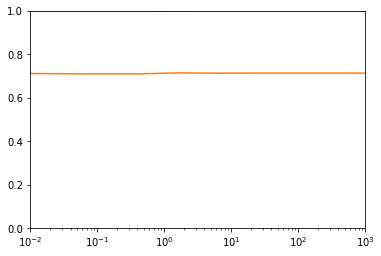

In [317]:
plt.xscale('log')
plt.axis([min(np.logspace(-2, 3, num=2)), max(np.logspace(-2, 3, num=2)), 0, 1])
plt.plot(np.logspace(-2, 3, num=10), np.mean(train_scores, axis=1))
plt.plot(np.logspace(-2, 3, num=10), np.mean(valid_scores, axis=1))
plt.show()

In [319]:
train_scores, valid_scores = validation_curve(SVC(), scaler.transform(train_X), main_df.has_support_case.ravel(), 'gamma', parameter_distrib['gamma'], scoring = "roc_auc", n_jobs=3)

In [117]:
train_scores, valid_scores

(array([[ 0.65749235,  0.63936721,  0.61190308],
        [ 0.65478711,  0.67218302,  0.63597977],
        [ 0.95797459,  0.91848977,  0.82695836],
        [ 0.99996471,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]]),
 array([[ 0.64643613,  0.54537756,  0.64234298],
        [ 0.62799341,  0.59289579,  0.67946366],
        [ 0.64050812,  0.63298048,  0.56645495],
        [ 0.58365091,  0.62262997,  0.62540579],
        [ 0.50764526,  0.50458716,  0.50152905]]))

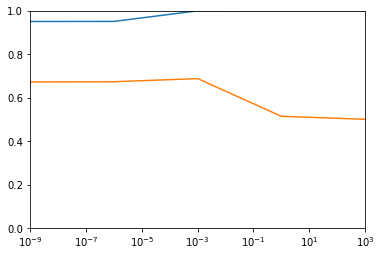

In [320]:
plt.xscale('log')
plt.axis([min(parameter_distrib['gamma']), max(parameter_distrib['gamma']), 0, 1])
plt.plot(parameter_distrib['gamma'], np.mean(train_scores, axis=1))
plt.plot(parameter_distrib['gamma'], np.mean(valid_scores, axis=1))
plt.show()

Gamma value has its optimal value between 10e-07 to 10e-05. Beyond this value we get an overfitted model.

In [321]:
train_scores, valid_scores = validation_curve(SVC(kernel='linear'), scaler.transform(train_X), main_df.has_support_case.ravel(), 'C', parameter_distrib['C'], scoring = "roc_auc", n_jobs=3)

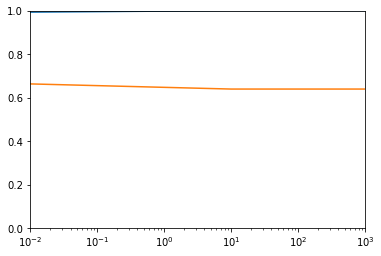

In [322]:
plt.xscale('log')
plt.axis([min(np.logspace(-2, 3, num=2)), max(np.logspace(-2, 3, num=2)), 0, 1])
plt.plot(parameter_distrib['C'], np.mean(train_scores, axis=1))
plt.plot(parameter_distrib['C'], np.mean(valid_scores, axis=1))
plt.show()

In [142]:
train_scores, valid_scores = validation_curve(MultinomialNB(), train_X_ex, main_df.has_support_case.ravel(), 'alpha',  np.linspace(0, 10), scoring = "roc_auc", n_jobs=3)

/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


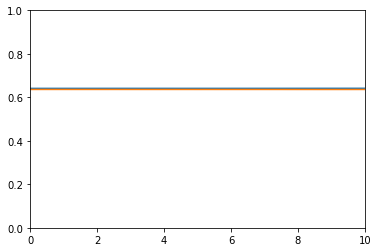

In [144]:
plt.axis([0, 10, 0, 1])
plt.plot(np.linspace(0,10), np.mean(train_scores, axis=1))
plt.plot(np.linspace(0, 10), np.mean(valid_scores, axis=1))
plt.show()

In [145]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## Random Forest

In [189]:
train_scores, valid_scores = validation_curve(RandomForestClassifier(), X_comb[:, [x for x in range(0, 100)] + [562, 563, 564]], y_comb, 'n_estimators',  [10, 50, 100, 10000], scoring = "roc_auc", n_jobs=3)

In [160]:
valid_scores

array([[ 0.87703761,  0.97039177,  0.93920884],
       [ 0.91568265,  0.99141441,  0.99211651],
       [ 0.93321605,  0.99766304,  0.99146456],
       [ 0.94872177,  0.99757277,  0.99394195],
       [ 0.95995348,  0.99903713,  0.99616858]])

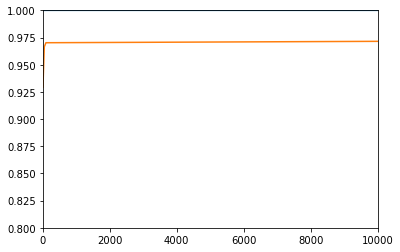

In [190]:
plt.axis([10, 10000, 0.8, 1])
plt.plot([10, 50, 100, 10000], np.mean(train_scores, axis=1))
plt.plot([10, 50, 100, 10000], np.mean(valid_scores, axis=1))
plt.show()

In [291]:
rf_class = RandomForestClassifier()
rf_class.fit(train_X[train_indx, :], main_df.has_support_case.ravel()[train_indx])
prediction_rf = rf_class.predict(train_X[train_indx, :])
print(u"Train AUC : {:.2f} \nTrain F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[train_indx], prediction_rf),
                                                     f1_score(main_df.has_support_case.ravel()[train_indx], prediction_rf)))
prediction_rf = rf_class.predict(train_X[test_indx, :])#svc_class.predict(train_X_ex[test_indx, :])

print(u"Test AUC : {:.2f} \nTest F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[test_indx], prediction_rf),
                                                   f1_score(main_df.has_support_case.ravel()[test_indx], prediction_rf)))

Train AUC : 0.95 
Train F1: 0.95
Test AUC : 0.58 
Test F1: 0.27


Using subset of data for testing and validating.

In [303]:
rf_class = RandomForestClassifier()
rf_class.fit(train_X[:,  [x for x in range(0, 100)] + [562, 563, 564]][train_indx], main_df.has_support_case.ravel()[train_indx])
prediction_rf = rf_class.predict(train_X[:,  [x for x in range(0, 100)] + [562, 563, 564]][train_indx])
print(u"Train AUC : {:.2f} \nTrain F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[train_indx], prediction_rf),
                                                     f1_score(main_df.has_support_case.ravel()[train_indx], prediction_rf)))
prediction_rf = rf_class.predict(train_X[:,  [x for x in range(0, 100)] + [562, 563, 564]][test_indx])#svc_class.predict(train_X_ex[test_indx, :])

print(u"Test AUC : {:.2f} \nTest F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[test_indx], prediction_rf),
                                                   f1_score(main_df.has_support_case.ravel()[test_indx], prediction_rf)))

Train AUC : 0.93 
Train F1: 0.93
Test AUC : 0.57 
Test F1: 0.26


Using SMOTE training set and validating on test data.

In [305]:
rf_class = RandomForestClassifier()
rf_class.fit(X_comb[:, [x for x in range(0, 100)] + [562, 563, 564]], y_comb)
prediction_rf = rf_class.predict(X_comb[:, [x for x in range(0, 100)] + [562, 563, 564]])
print(u"Train AUC : {:.2f} \nTrain F1: {:.2f}".format(roc_auc_score(y_comb, prediction_rf),
                                                     f1_score(y_comb, prediction_rf)))
prediction_rf = rf_class.predict(train_X[:,  [x for x in range(0, 100)] + [562, 563, 564]][test_indx])#svc_class.predict(train_X_ex[test_indx, :])

print(u"Test AUC : {:.2f} \nTest F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[test_indx], prediction_rf),
                                                   f1_score(main_df.has_support_case.ravel()[test_indx], prediction_rf)))

Train AUC : 1.00 
Train F1: 1.00
Test AUC : 0.63 
Test F1: 0.39


In [360]:
rf_class = RandomForestClassifier(n_estimators=1000)
rf_class.fit(X_comb, y_comb)
prediction_rf = rf_class.predict(X_comb)
print(u"Train AUC : {:.2f} \nTrain F1: {:.2f}".format(roc_auc_score(y_comb, prediction_rf),
                                                     f1_score(y_comb, prediction_rf)))
prediction_rf = rf_class.predict(train_X[test_indx, :])#svc_class.predict(train_X_ex[test_indx, :])

print(u"Test AUC : {:.2f} \nTest F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[test_indx], prediction_rf),
                                                   f1_score(main_df.has_support_case.ravel()[test_indx], prediction_rf)))

Train AUC : 1.00 
Train F1: 1.00
Test AUC : 0.62 
Test F1: 0.39


## Learning Curves

In [118]:
from sklearn.model_selection import learning_curve

In [324]:
train_sizes, train_score, test_score = learning_curve(SVC(C=100, gamma=10e-04), train_X[:, [x for x in range(0, 50)] + [562, 563, 564]], main_df.has_support_case.ravel(), cv=StratifiedKFold(shuffle=True), scoring='roc_auc', n_jobs=3)

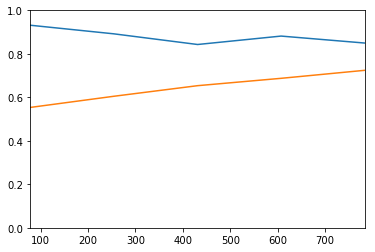

In [308]:
plt.axis([train_sizes[0], train_sizes[-1], 0, 1])
plt.plot(train_sizes, np.mean(train_score, axis=1))
plt.plot(train_sizes, np.mean(test_score, axis=1))
plt.show()

In [335]:
train_sizes, train_score, test_score = learning_curve(SVC(C=100, gamma=10e-04), scaler.transform(train_X), main_df.has_support_case.ravel(), cv=StratifiedKFold(shuffle=True), scoring='roc_auc', n_jobs=3)

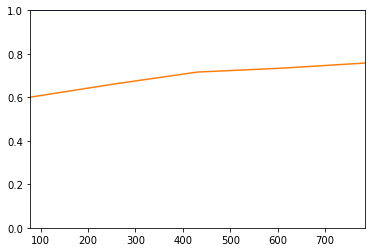

In [336]:
plt.axis([train_sizes[0], train_sizes[-1], 0, 1])
plt.plot(train_sizes, np.mean(train_score, axis=1))
plt.plot(train_sizes, np.mean(test_score, axis=1))
plt.show()

In [271]:
from xgboost import XGBClassifier, plot_importance

In [273]:
train_sizes, train_score, test_score = learning_curve(XGBClassifier(), train_X, main_df.has_support_case.ravel(), cv=StratifiedKFold(shuffle=True), scoring='roc_auc', 
                                                      n_jobs=3)

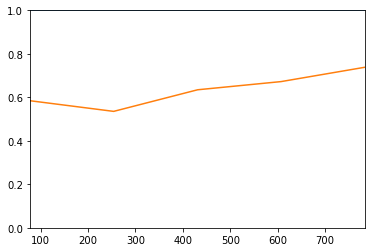

In [276]:
plt.axis([train_sizes[0], train_sizes[-1], 0, 1])
plt.plot(train_sizes, np.mean(train_score, axis=1))
plt.plot(train_sizes, np.mean(test_score, axis=1))
plt.show()

In [280]:
#plot_importance(XGBClassifier().fit(train_X, main_df.has_support_case.ravel()), importance_type="gain", ylim=(534, 564))
xgbc = XGBClassifier().fit(train_X, main_df.has_support_case.ravel())

In [337]:
sorted(zip(range(0, 565), xgbc.feature_importances_), key = lambda x: x[1], reverse=True)

[(10, 0.029411765),
 (17, 0.018575851),
 (19, 0.017027864),
 (2, 0.015479876),
 (93, 0.015479876),
 (27, 0.013931888),
 (55, 0.012383901),
 (244, 0.012383901),
 (4, 0.010835913),
 (15, 0.010835913),
 (29, 0.010835913),
 (33, 0.010835913),
 (304, 0.010835913),
 (306, 0.010835913),
 (380, 0.010835913),
 (510, 0.010835913),
 (13, 0.0092879254),
 (37, 0.0092879254),
 (42, 0.0092879254),
 (72, 0.0092879254),
 (92, 0.0092879254),
 (564, 0.0092879254),
 (0, 0.0077399379),
 (11, 0.0077399379),
 (22, 0.0077399379),
 (26, 0.0077399379),
 (43, 0.0077399379),
 (57, 0.0077399379),
 (74, 0.0077399379),
 (112, 0.0077399379),
 (141, 0.0077399379),
 (225, 0.0077399379),
 (430, 0.0077399379),
 (562, 0.0077399379),
 (8, 0.0061919503),
 (41, 0.0061919503),
 (84, 0.0061919503),
 (149, 0.0061919503),
 (158, 0.0061919503),
 (168, 0.0061919503),
 (178, 0.0061919503),
 (343, 0.0061919503),
 (404, 0.0061919503),
 (407, 0.0061919503),
 (420, 0.0061919503),
 (429, 0.0061919503),
 (454, 0.0061919503),
 (466, 0.006

In [285]:
len(xgbc.feature_importances_)

565

In [345]:
xgbc.fit(train_X[train_indx, :], main_df.has_support_case.ravel()[train_indx])
prediction_xgbc = xgbc.predict(train_X[train_indx, :])
print(u"Train AUC : {:.2f} \nTrain F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[train_indx], prediction_xgbc),
                                                     f1_score(main_df.has_support_case.ravel()[train_indx], prediction_xgbc)))
prediction_xgbc = xgbc.predict(train_X[test_indx, :])#svc_class.predict(train_X_ex[test_indx, :])

print(u"Test AUC : {:.2f} \nTest F1: {:.2f}".format(roc_auc_score(main_df.has_support_case.ravel()[test_indx], prediction_xgbc),
                                                   f1_score(main_df.has_support_case.ravel()[test_indx], prediction_xgbc)))

Train AUC : 1.00 
Train F1: 1.00
Test AUC : 0.60 
Test F1: 0.33


## Conclusions

- The best scores were achieved by SVM classifier
- We used XGBoost to validate the feature importance
- Important features are the number of code blocks in the documents and the length of a document. This points out to the complexity of a topic
